# Sentiment Analysis

### Import dependencies

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import requests
from bs4 import BeautifulSoup
import re
from math import ceil

### Load model

In [2]:
tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")

### Collect data

In [3]:
def collect_review(soup):

    regex_date = re.compile('.*ratingDate*')
    results_date = soup.find_all('span', {'class': regex_date})

    regex_title = re.compile('.*noQuotes*')
    results_title = soup.find_all('span', {'class':regex_title})

    regex_comment = re.compile('.*partial_entry.*')
    results_comment = soup.find_all('p', {'class':regex_comment})

    review_date_list = []
    user_rating_list = []
    review_title_list = []
    review_list = []
    
    for date, title, review in zip(results_date, results_title, results_comment):
        # Extract the review date
        review_date = date.get('title')
        review_date_list.append(review_date)

        # Find the user rating just before the review date
        user_rating = date.find_previous('span', {'class': 'ui_bubble_rating'})
        rating = int(int(user_rating['class'][1].split('_')[-1]) / 10)
        user_rating_list.append(rating)

        # Extract the review title
        result_title = title.text
        review_title_list.append(result_title)

        # Extract the review

        result_review = review.text
        review_list.append(result_review)
    
    reviews = {'review_date': review_date_list, 
            'user_rating' : user_rating_list,
            'review_title' : review_title_list,
            'review' : review_list}
    
    return reviews

In [4]:
def get_soup(url):
    headers = {
    'User-Agent' : 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/115.0.0.0 Safari/537.36',
    'Accept-Language' : 'en-US,en;q=0.9',
    'Referer' : 'https://google.com',
    'DNT' : '1'
    }
    response = requests.get(url, headers=headers)
    #print(response.status_code)
    if (response.status_code!=200):
        return None
    soup = BeautifulSoup(response.text, 'html.parser')
    return soup

In [5]:
def combine_dicts(dict1, dict2):
    combined_dicts = {}

    for key in dict1.keys():
        combined_dicts[key] = dict1[key]+dict2[key]
    
    return combined_dicts

In [6]:
def get_reviews(base_url, max_reviews=15):
    pattern = r'(https?://[^/]+)(/Restaurant_Review-g\d+-d\d+-Reviews-)(.*)'
    url_split = re.search(pattern, base_url)

    website = url_split.group(1)
    path_part_a = url_split.group(2)
    path_part_b = url_split.group(3)

    if path_part_b[:2]=='or':
        pattern2 = r'(or\d+-)(.*)'
        split2 = re.search(pattern2, path_part_b)
        path_part_b = split2.group(2)
    

    reviews = {'review_date': [], 
            'user_rating' : [],
            'review_title' : [],
            'review' : []}

    for i in range(ceil(max_reviews/15)):
        if i==0:
            url = website+path_part_a+path_part_b
        else:
            url = website+path_part_a+'or{}-'.format(i*15)+path_part_b
        
        soup = get_soup(url)
        if soup == None:
            return reviews
        else:
            reviews = combine_dicts(reviews, collect_review(soup))
    
    return reviews

In [7]:
url = 'https://www.tripadvisor.in/Restaurant_Review-g297635-d1205738-Reviews-Hotel_Paragon_Restaurant-Kozhikode_Kozhikode_District_Kerala.html'
max_reviews = 300

reviews_df = pd.DataFrame(get_reviews(url, max_reviews))

In [8]:
reviews_df

,review_date,user_rating,review_title,review
0,31 July 2023,4,"Timeless Charm, Excellent Service, Amazing Foo...","One of the oldest restaurants in town, I was i..."
1,31 May 2023,5,Great place for non-veg Kerala food in Kozhiko...,Been here for breakfast and late lunch on our ...
2,15 May 2023,5,Best restaurant since 1939,Paragon is a Kozhikode institution with an unm...
3,26 April 2023,4,Very good to check out Indian cuisine,Indeed very good food (at a price). Went here ...
4,1 April 2023,2,Lunch at Paragon Kozhikkode,Went for lunch with family . A very crowded pl...
...,...,...,...,...
295,6 September 2017,5,Re - Paragon Calicut,Ambiance is good and staff is courteous same a...
296,6 September 2017,5,Superb quality food,"My target was to have a great lunch ""non-veg b..."
297,6 September 2017,3,Good non veg restaurant,This is a very famous and old and we'll establ...
298,6 September 2017,5,Lovely food,Very interesting unique food.it is really good...


In [9]:
# Save reviews
csv_file = 'paragon_reviews_300.csv'
reviews_df.to_csv(csv_file, index=False, quotechar='"', quoting=1)

### Predict sentiments

In [10]:
def bert_sentiment(review):
    tokens = tokenizer.encode(review, return_tensors='pt')
    result = model(tokens)
    return int(torch.argmax(result.logits))+1

In [11]:
reviews_df['HF_BERT_sentiment'] = (reviews_df['review_title'] + '. ' + reviews_df['review']).apply(lambda x: bert_sentiment(x[:512]))

In [12]:
reviews_df

,review_date,user_rating,review_title,review,HF_BERT_sentiment
0,31 July 2023,4,"Timeless Charm, Excellent Service, Amazing Foo...","One of the oldest restaurants in town, I was i...",5
1,31 May 2023,5,Great place for non-veg Kerala food in Kozhiko...,Been here for breakfast and late lunch on our ...,5
2,15 May 2023,5,Best restaurant since 1939,Paragon is a Kozhikode institution with an unm...,5
3,26 April 2023,4,Very good to check out Indian cuisine,Indeed very good food (at a price). Went here ...,5
4,1 April 2023,2,Lunch at Paragon Kozhikkode,Went for lunch with family . A very crowded pl...,3
...,...,...,...,...,...
295,6 September 2017,5,Re - Paragon Calicut,Ambiance is good and staff is courteous same a...,4
296,6 September 2017,5,Superb quality food,"My target was to have a great lunch ""non-veg b...",5
297,6 September 2017,3,Good non veg restaurant,This is a very famous and old and we'll establ...,4
298,6 September 2017,5,Lovely food,Very interesting unique food.it is really good...,5


### Comparison with Rules-based Sentiment Analysis

We can check the predictions made by `TextBlob` and `VADER` for comparison

#### `TextBlob`

In [13]:
from textblob import TextBlob

In [14]:
def textblob_sentiment(review):
    return round((TextBlob(review).sentiment.polarity*2)+3)

#### `VADER`

In [15]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/georgethomas/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [16]:
def vader_sentiment(review):
    return round((sid.polarity_scores(review)['compound']*2)+3)

#### Predict sentiments

In [17]:
reviews_df['TextBlob_sentiment'] = (reviews_df['review_title'] + '. ' + reviews_df['review']).apply(lambda x: textblob_sentiment(x[:512]))
reviews_df['VADER_sentiment'] = (reviews_df['review_title'] + '. ' + reviews_df['review']).apply(lambda x: vader_sentiment(x[:512]))

In [18]:
reviews_df

,review_date,user_rating,review_title,review,HF_BERT_sentiment,TextBlob_sentiment,VADER_sentiment
0,31 July 2023,4,"Timeless Charm, Excellent Service, Amazing Foo...","One of the oldest restaurants in town, I was i...",5,4,5
1,31 May 2023,5,Great place for non-veg Kerala food in Kozhiko...,Been here for breakfast and late lunch on our ...,5,3,5
2,15 May 2023,5,Best restaurant since 1939,Paragon is a Kozhikode institution with an unm...,5,4,5
3,26 April 2023,4,Very good to check out Indian cuisine,Indeed very good food (at a price). Went here ...,5,4,5
4,1 April 2023,2,Lunch at Paragon Kozhikkode,Went for lunch with family . A very crowded pl...,3,3,4
...,...,...,...,...,...,...,...
295,6 September 2017,5,Re - Paragon Calicut,Ambiance is good and staff is courteous same a...,4,4,5
296,6 September 2017,5,Superb quality food,"My target was to have a great lunch ""non-veg b...",5,3,5
297,6 September 2017,3,Good non veg restaurant,This is a very famous and old and we'll establ...,4,4,5
298,6 September 2017,5,Lovely food,Very interesting unique food.it is really good...,5,4,5


### Performance Evaluation

In [19]:
true_sentiments = reviews_df['user_rating']

In [20]:
def performance_metrics(true_sentiments, predicted_sentiments):
    # Calculate accuracy
    accuracy = sum(1 for true, pred in zip(true_sentiments, predicted_sentiments) if true == pred) / len(true_sentiments)
    print("Accuracy: {:.2f}".format(accuracy))

    # Calculate confusion matrix
    cm = confusion_matrix(true_sentiments, predicted_sentiments)
    print("Confusion Matrix:")
    print(cm)

    # Calculate precision, recall, and F1-score
    classification_rep = classification_report(true_sentiments, predicted_sentiments, zero_division=1)
    print("Classification Report:")
    print(classification_rep)

#### BERT Scores

In [21]:
performance_metrics(true_sentiments, reviews_df['HF_BERT_sentiment'])

Accuracy: 0.61
Confusion Matrix:
[[  7   0   2   0   0]
 [  0   2   1   0   0]
 [  0   5   2   5   1]
 [  2   2  11  29  45]
 [  2   1   4  37 142]]
Classification Report:
              precision    recall  f1-score   support

           1       0.64      0.78      0.70         9
           2       0.20      0.67      0.31         3
           3       0.10      0.15      0.12        13
           4       0.41      0.33      0.36        89
           5       0.76      0.76      0.76       186

    accuracy                           0.61       300
   macro avg       0.42      0.54      0.45       300
weighted avg       0.61      0.61      0.61       300



#### TextBlob Scores

In [22]:
performance_metrics(true_sentiments, reviews_df['TextBlob_sentiment'])

Accuracy: 0.25
Confusion Matrix:
[[  0   4   3   2   0]
 [  0   0   2   1   0]
 [  0   1   7   4   1]
 [  0   1  28  54   6]
 [  0   2  45 126  13]]
Classification Report:
              precision    recall  f1-score   support

           1       1.00      0.00      0.00         9
           2       0.00      0.00      1.00         3
           3       0.08      0.54      0.14        13
           4       0.29      0.61      0.39        89
           5       0.65      0.07      0.13       186

    accuracy                           0.25       300
   macro avg       0.40      0.24      0.33       300
weighted avg       0.52      0.25      0.21       300



#### VADER Scores

In [23]:
performance_metrics(true_sentiments, reviews_df['VADER_sentiment'])

Accuracy: 0.52
Confusion Matrix:
[[  2   6   0   1   0]
 [  0   1   1   1   0]
 [  1   0   4   4   4]
 [  0   3   9  21  56]
 [  0   3   8  48 127]]
Classification Report:
              precision    recall  f1-score   support

           1       0.67      0.22      0.33         9
           2       0.08      0.33      0.12         3
           3       0.18      0.31      0.23        13
           4       0.28      0.24      0.26        89
           5       0.68      0.68      0.68       186

    accuracy                           0.52       300
   macro avg       0.38      0.36      0.32       300
weighted avg       0.53      0.52      0.52       300



### Plots

<Axes: title={'center': 'Actual user rating'}, xlabel='user_rating'>

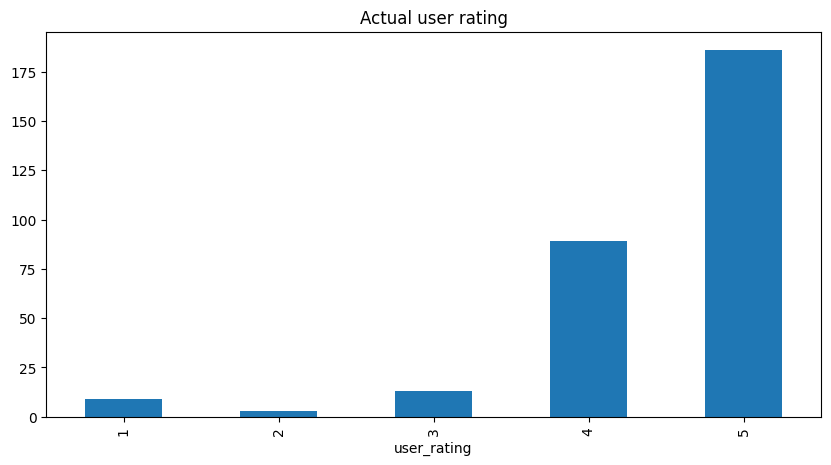

In [24]:
reviews_df['user_rating'].value_counts().sort_index().plot(kind='bar', title='Actual user rating', figsize=(10,5))

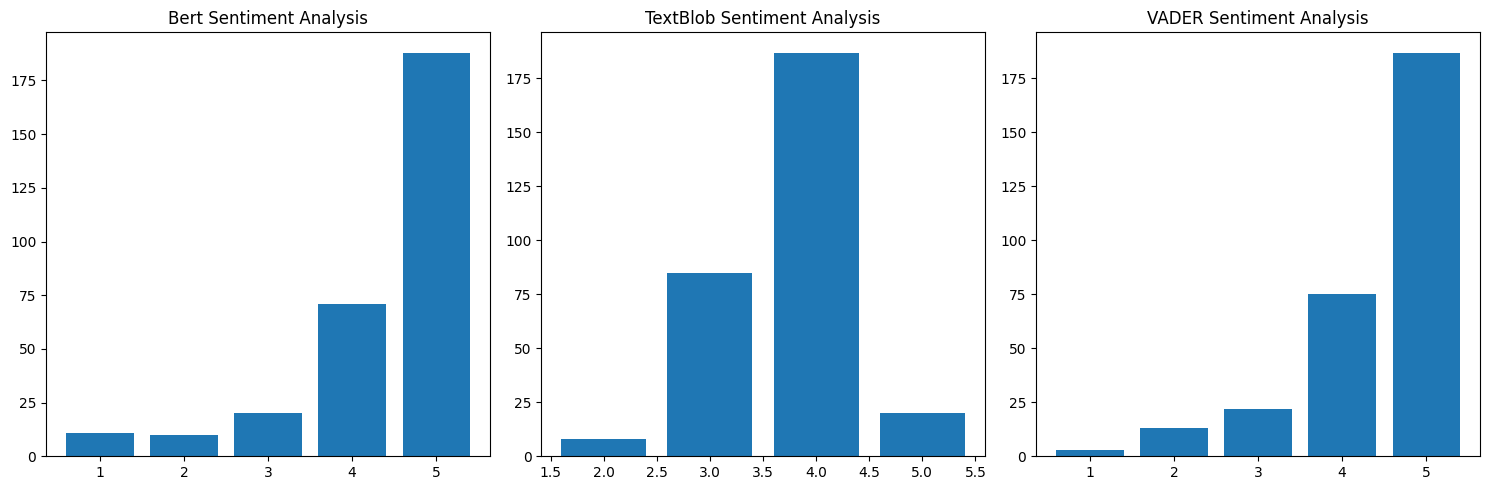

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].bar(reviews_df['HF_BERT_sentiment'].value_counts().sort_index().index, 
            reviews_df['HF_BERT_sentiment'].value_counts().sort_index().values)
axes[0].set_title('Bert Sentiment Analysis')

axes[1].bar(reviews_df['TextBlob_sentiment'].value_counts().sort_index().index, 
            reviews_df['TextBlob_sentiment'].value_counts().sort_index().values)
axes[1].set_title('TextBlob Sentiment Analysis')

axes[2].bar(reviews_df['VADER_sentiment'].value_counts().sort_index().index, 
            reviews_df['VADER_sentiment'].value_counts().sort_index().values)
axes[2].set_title('VADER Sentiment Analysis')

plt.tight_layout()
plt.show()